## 🔰PyTorchでニューラルネットワーク基礎 #17 【分位点回帰】

### 内容
* Qiitaの記事と連動
* ニューラルネットワークを利用した分位点回帰の演習
* データはスポーツ飲料と気温の関係

### ニューラルネットワークによる分位点回帰
* 分位点をもとに回帰分析する方法
* 楽観的、悲観的、通常と幅のある予測が可能となる
* 現在の販売状況から3種類（分位点の数）のシナリオで判断できる。


### スポーツ飲料と気温の関係
* [全国清涼飲料連合会](https://www.j-sda.or.jp/index.php)
* [気象庁共同プロジェクト](https://www.j-sda.or.jp/about/comprehensive_measures/weather/kekka04.php)
* 気象庁共同プロジェクトからDL4.xlsファイルをダウンロード、sports_temp.csvとファイル名を変更して利用します

In [ ]:
import pandas as pd
df = pd.read_csv("./data/sports_temp.csv")
df.head()

### ニューラルネットワークモデル

In [3]:
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

#デバイスの選択
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("Using Device Name:", device)

Using Device Name: cuda:0


In [4]:
x = df["平均気温"]
t = df["販売指数"]

# torchテンソルに変換
x = torch.FloatTensor(x).view(-1,1).to(device)
t = torch.FloatTensor(t).view(-1,1).to(device)

x_train, x_test, t_train, t_test = train_test_split(x,t,random_state=55)

### ネットワークの定義
* 全結合層2層と活性化関数で非線形化
* 最終出力が分位点数（0.1、0.5、0.9の3種類）

In [5]:
class DNN(nn.Module):
    def __init__(self):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(in_features=1, out_features=8)
        self.bn1 = nn.BatchNorm1d(8)
        self.act1 = nn.Sigmoid()
        self.fc2 =  nn.Linear(in_features=8, out_features=3)

    def forward(self, x):
        h = self.fc1(x)
        h = self.bn1(h)
        h = self.act1(h)
        y = self.fc2(h)
        return y

### 分位点回帰の損失関数
* ピンボール関数を利用する

In [6]:
# 損失関数のクラスと定義
class PinballLoss(nn.Module):
    def __init__(self, quantiles, device="cpu"):
        super().__init__()
        self.quantiles = torch.FloatTensor(quantiles).to(device)
        
    def forward(self, pred_values, actual_values):
        error = actual_values - pred_values
        # ピンボール損失の計算: max((q-1)*residual, q*residual)
        M = torch.max((self.quantiles - 1) * error, self.quantiles * error)
        loss = M.mean(dim=0).sum()     # 各分位点での損失平均を取り、合計する
        return loss

In [7]:
# 分位点の設定
quantiles = [0.1, 0.5, 0.9]

In [8]:
model = DNN()
model.to(device)

DNN(
  (fc1): Linear(in_features=1, out_features=8, bias=True)
  (bn1): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): Sigmoid()
  (fc2): Linear(in_features=8, out_features=3, bias=True)
)

### 損失関数を指定
* 回帰モデルだけど、MSELossではなく分位点回帰なので作成した**PinballLoss**を使う

In [9]:
criterion = PinballLoss(quantiles=quantiles, device=device)
optimizer = torch.optim.Adam(model.parameters())

In [10]:
LOOP = 5000
for epoch in range(LOOP):
    optimizer.zero_grad()
    y = model(x)
    loss = criterion(y, t)
    loss.backward()
    optimizer.step()
    if (epoch+1)%1000 == 0:
        print(f"{epoch}: loss: {loss.item()}")

999: loss: 0.20229321718215942
1999: loss: 0.16672971844673157
2999: loss: 0.15055570006370544
3999: loss: 0.14460760354995728
4999: loss: 0.14255443215370178


### 可視化

## モデルの予測線を描画する
* 平均気温の最小値〜最大値の範囲で100分割（temp_range）して、予測線の入力値とする
* 予測線は、temp_rangeに対してplotする

In [11]:
model.eval()
np_temp_range = np.linspace(df['平均気温'].min(), df['平均気温'].max(), 100)
temp_range = torch.FloatTensor(np_temp_range).view(-1,1).to(device)

with torch.inference_mode():
    pred = model(temp_range)
pred = pred.cpu().detach().numpy()

# predの形状が、分位点3個毎になる
pred.shape

(100, 3)

In [12]:
import matplotlib.pyplot as plt
import japanize_matplotlib

### 検証データでチェック
* ○マークがテストデータ
* 予測範囲内に収まっているのかチェック
* 0.1線と0.9線の間が80%起きる確率
* 26, 27度のあたり、0.1分位の予測線を下回っている

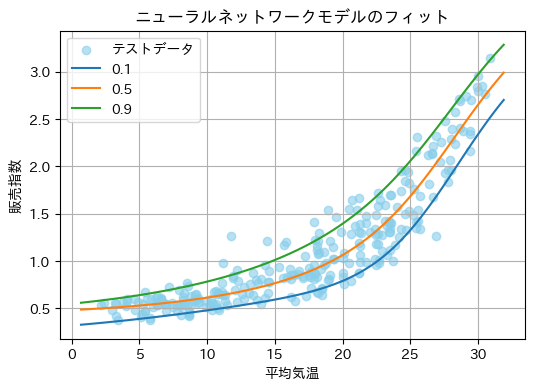

In [13]:
np_x_test = x_test.detach().cpu().numpy()
np_t_test = t_test.detach().cpu().numpy()

fig, ax = plt.subplots(figsize=(6,4))
ax.scatter(np_x_test, np_t_test, color="skyblue", label="テストデータ", alpha=0.6)  # 実際のデータを散布図としてプロット
for i, t in enumerate(quantiles):
    # 予測曲線をプロット
    ax.plot(np_temp_range, pred.T[i], label=t)
# グラフのタイトルとラベルを設定
ax.set_title("ニューラルネットワークモデルのフィット")
ax.set_xlabel("平均気温")
ax.set_ylabel("販売指数")
ax.legend()
ax.grid()
plt.show()

### 気温から販売指数を予測してみた

In [ ]:
# 代表的な気温を入力データとして準備
temp = torch.FloatTensor([[20],[25],[30],[35],[40]]).to(device)   # FloatTensorだよ
prediction = model(temp)    # model(temp)で予測値が計算される。出力は３種類（分位点0.1〜0.9）

# 表の形で出力してみた
pred_df = pd.DataFrame(temp.detach().cpu().numpy(), columns=["気温"])
pred_df[["悲観的(0.1)","通常(0.5)","楽観的(0.9)"]] = pd.DataFrame(prediction.detach().cpu().numpy())
pred_df

,気温,悲観的(0.1),通常(0.5),楽観的(0.9)
0,20.0,0.788900,1.062313,1.393680
1,25.0,1.325872,1.683748,2.057495
2,30.0,2.338599,2.651761,2.971779
3,35.0,3.141405,3.414234,3.684154
4,40.0,3.528803,3.809758,4.066600
